<a name="3"></a>
##  Regularized Logistic Regression

###  Problem Statement

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. 
- From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
- To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

<a name="3.2"></a>
### 1. Loading and visualizing the data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import copy
import math
from public_tests import *
%matplotlib inline
print('Ready to go')

Ready to go


In [7]:
X_train, y_train = load_data("data/ex2data2.txt")


### Check the dimensions of your variables
- print the first five values of X_train and y_train and their type

In [8]:
# print X_train
print('X_train:', X_train[:5])
print('Type of X_train:',type(X_train))

# print y_train
print('y_train:', y_train[:5])
print('Type of y_train', type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train <class 'numpy.ndarray'>


### Check the dimensions of your variables

In [9]:
### Check the dimensions of your variables
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('We have  m = %d training examples' %(len(y_train)))

X_train shape: (118, 2)
y_train shape: (118,)
We have  m = 118 training examples


### 2. Visualize your data

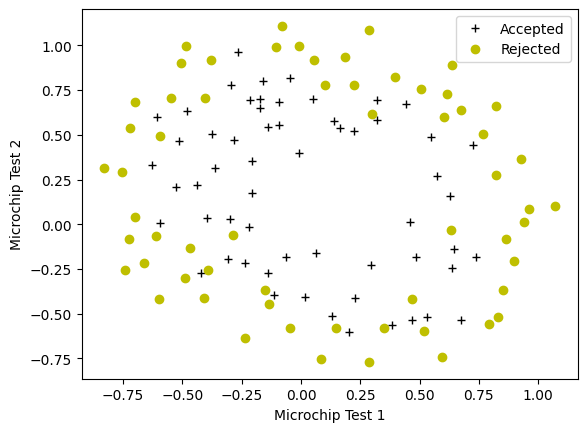

In [10]:
### Visualize your data
plot_data(X_train, y_train, pos_label="Accepted", neg_label="Rejected")

# label axis
plt.ylabel("Microchip Test 2")
plt.xlabel("Microchip Test 1")

plt.legend(loc="upper right")
plt.show()

The plot shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 3. Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 

In [11]:
print('Original shape of data:', X_train.shape)

mapped_X = map_feature(X_train[:, 0], X_train[:, 1])
print('Shape after mapping feature:', mapped_X.shape)


Original shape of data: (118, 2)
Shape after mapping feature: (118, 27)


In [12]:
# mapped_X[:1] # confirm the 27 rows

Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [13]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])


X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting.
- regularization can help combat the overfitting problem.

### `Recall` the cost function on unregularized logistic regression

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    g = 1/(1+np.exp(-z))
    ### END SOLUTION ###  
    
    return g

In [15]:
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    ### START CODE HERE ###
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb = sigmoid(z)
        cost += -y[i]*np.log(f_wb) - (1-y[i])*np.log(1-f_wb)
    total_cost = cost/m
    
    ### END CODE HERE ### 

    return total_cost

### 4. Cost function for regularized logistic regression

In this part, you will implement the cost function for regularized logistic regression.

For regularized logistic regression, the cost function is of the form:
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$
Without regularization (which you implemented above), which is of the form:

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

Let's complete the `compute_cost_reg` function below to calculate the following term for each element in $w$ 
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

In [16]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
      """
      
    m, n = X.shape

    # Call the compute_cost function implemented earlier
    cost_without_reg = compute_cost(X, y, w, b)

    # You need to calculate this value
    reg_cost = 0

    ### CODE START
    reg_cost = sum(np.square(w))
    ### CODE END

    # Add the regularized cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2*m)) * reg_cost
    
    return total_cost


Check the implementation of the `compute_cost_reg` function

In [17]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5  # Shifts the range from [0, 1] to [-0.5, 0.5]
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)
print('Regularized cost: ', cost)

# UNIT TEST
compute_cost_reg_test(compute_cost_reg)

Regularized cost:  0.6618252552483948
All tests passed!


`Recall the gradient for unregularized Logistic regression`

In [18]:
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                       
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   
        
    ### END CODE HERE ###

        
    return dj_db, dj_dw

### 5. Gradient for regularized logistic regression

In this section, you will implement the gradient for regularized logistic regression.


In [19]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (ndarray Shape (m,n))   variable such as house size 
      y : (ndarray Shape (m,))    actual value 
      w : (ndarray Shape (n,))    values of parameters of the model      
      b : (scalar)                value of parameter of the model  
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape

    dj_db, dj_dw = compute_gradient(X, y, w, b)

    ### CODE START
    for j in range(n):
      dj_dw[j] += (lambda_/m) * w[j]
    ### CODE END

    return dj_db, dj_dw

Check the implementation of `gradient_descent_reg`


In [20]:
from zipfile._path import InitializedState


X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f'dj_db: {dj_db}', )
print(f"First few elements of dj_dw:\n {dj_dw[:4].tolist()}")

compute_gradient_reg_test(compute_gradient_reg)

dj_db: 0.07138288792343662
First few elements of dj_dw:
 [-0.010386028450548701, 0.011409852883280122, 0.0536273463274574, 0.003140278267313462]
All tests passed!


### 6. gradient descent for regularized Logistic regression

In [21]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

### 7. Learning parameters using gradient descent
- If you have completed the cost and gradient for regularized logistic regression correctly, you should be able to step through the next cell to learn the parameters $w$. 
- After training our parameters, we will use it to plot the decision boundary. 

In [22]:
# Initialize fitting parameter
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 1.

# Set the regularization parameter lambda_ to 1  (you can try varying this)
lambda_ = 0.001
# Some gradient descent settings
iterations = 15000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, compute_cost_reg, compute_gradient_reg, alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1500: Cost     0.57   
Iteration 3000: Cost     0.53   
Iteration 4500: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7500: Cost     0.47   
Iteration 9000: Cost     0.45   
Iteration 10500: Cost     0.44   
Iteration 12000: Cost     0.43   
Iteration 13500: Cost     0.42   
Iteration 14999: Cost     0.42   


### 8. Plotting the decision boundary

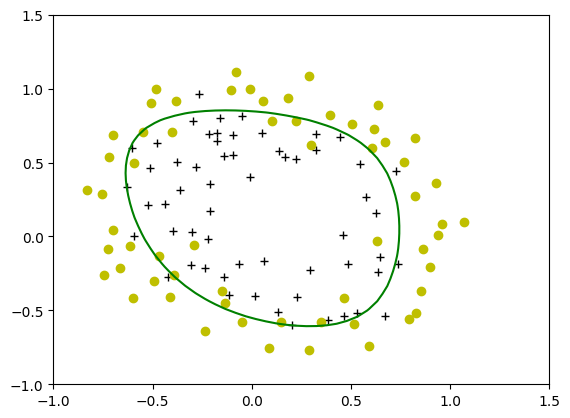

In [23]:
plot_decision_boundary(w, b, X_mapped, y_train)

Recall the `Predict` function

In [24]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    # Loop over each example
    for i in range(m):   
        z_wb = np.dot(X[i],w) 
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += 0
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb>0.5 else 0
        
    ### END CODE HERE ### 
    return p

### 9. Evaluating regularized logistic regression model
Calculate the accuracy of the regulaized logistic regression model on the training set using `predict`

In [25]:
# Compute the accuracy on the training set
p = predict(X_mapped, w, b)
print('Train Accuracy: %f'%(np.mean(p == y_train)*100))

Train Accuracy: 82.203390
